# Alignment Neuroendocrine 
in vitro=

Hor_2020_iPNECs: Efficient generation and transcriptomic profiling of human iPSC-derived pulmonary neuroendocrine cells.

Conchola_2023: PNEC from primary human bud tip organoids (BTOs).

Lee_2023: PNEC from A single-cell atlas of in vitro multiculture systems.

Dayton_lab.

in vivo=

Conchola_2023:

Travaglini_2020:

Basil 2022:

## Imports

In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import os, tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import scanpy.external as sce
import anndata as ad
from scipy.sparse import hstack
from collections import Counter
import biomart 
from biomart import BiomartServer
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.sparse import csr_matrix

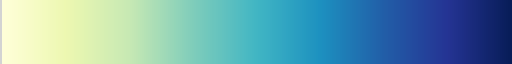

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## Figure Settings

In [3]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

figfolder='./figures'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Inspect matrixes AnnData

In [4]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")

## Loading and merging individual datasets

### Hor et al., (2020)

In [5]:
adata_hor=sc.read_h5ad('./data/Hor2020/Hor2020_iPNECs_processed.h5ad')
metadata_hor=adata_hor.obs
metadata_hor = metadata_hor[metadata_hor['majority_voting'] == 'PNEC']
condition_mask = adata_hor.obs_names.isin(metadata_hor.index)
adata_hor = adata_hor[condition_mask]
adata_hor.obs['Tissue']= 'iPNECs'
adata_hor.obs['Reference']= 'Hor et al., (2020)'
adata_hor.obs['Technique']= '10x'

adata_hor

AnnData object with n_obs × n_vars = 786 × 33677
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes'
    uns: 'leiden', 'log1p', 'majority_voting_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
matrix_summary(adata_hor)

Expression matrix (X): min=0.0, max=7.532164096832275, mean=0.09659730643033981
Counts layer matrix (layers['counts']): min=0.0, max=1963.0, mean=0.2574319541454315
Raw matrix (raw.X): min=0.0, max=7.532164096832275, mean=0.09659730643033981
Scaled layer not found in adata.layers.


### Conchola et al., (2023)

In [7]:
adata_conchola_bto=sc.read_h5ad('./data/Conchola2023/Conchola2023CellTagging_processed.h5ad')
metadata_conchola_bto=adata_conchola_bto.obs
metadata_conchola_bto = metadata_conchola_bto[metadata_conchola_bto['majority_voting'] == 'PNEC']
condition_mask = adata_conchola_bto.obs_names.isin(metadata_conchola_bto.index)
adata_conchola_bto = adata_conchola_bto[condition_mask]
adata_conchola_bto.obs['Tissue']= 'BTOs'
adata_conchola_bto.obs['Reference']= 'Conchola et al., (2023) - BTOs'
adata_conchola_bto.obs['Technique']= '10x'

adata_conchola_bto

AnnData object with n_obs × n_vars = 164 × 24402
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'Sample ID', 'Tissue', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique'
    uns: 'celltype_colors', 'leiden', 'log1p', 'majority_voting_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
matrix_summary(adata_conchola_bto)

Expression matrix (X): min=0.0, max=7.410360813140869, mean=0.15045741200447083
Counts layer matrix (layers['counts']): min=0, max=6960, mean=1.0576442154881347
Raw matrix (raw.X): min=0.0, max=7.410360813140869, mean=0.15045741200447083
Scaled layer not found in adata.layers.


### Lee et al., (2023)

In [9]:
adata_lee=sc.read_h5ad('./data/Lee2023/Lee2023invitroAtlas_processed.h5ad')
metadata_lee=adata_lee.obs
metadata_lee = metadata_lee[metadata_lee['majority_voting'] == 'PNEC']
condition_mask = adata_lee.obs_names.isin(metadata_lee.index)
adata_lee = adata_lee[condition_mask]
adata_lee.obs['Tissue'] = 'dAOs/ALI'
adata_lee.obs['Sample ID'] = adata_lee.obs['orig.ident']
adata_lee.obs['Reference'] = 'Lee et al., (2023)'
adata_lee.obs['Technique']= '10x'

adata_lee

AnnData object with n_obs × n_vars = 171 × 36584
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'subclusters', 'sample_type_celltype', 'assignment_sample_type_celltype', 'passage', 'barcode', 'UMAP_1', 'UMAP_2', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Tissue', 'Sample ID', 'Reference', 'Technique'

In [10]:
matrix_summary(adata_lee)

Expression matrix (X): min=0.0, max=7.774810314178467, mean=0.09077293425798416
Counts layer matrix (layers['counts']): min=0, max=17590, mean=0.35944435492843196
Raw matrix (raw.X): min=0.0, max=7.774810314178467, mean=0.09077293425798416
Scaled layer not found in adata.layers.


### Dayton et al., (2025)

In [11]:
adata_dayton=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
metadata_dayton=adata_dayton.obs
metadata_dayton = metadata_dayton[
    (metadata_dayton['CELL_TYPE'] == 'PNEC') &
    (metadata_dayton['Time point'] == 'day10')]
condition_mask = adata_dayton.obs_names.isin(metadata_dayton.index)
adata_dayton = adata_dayton[condition_mask]
adata_dayton.obs['Tissue'] = 'NEr-fAOs'
adata_dayton.obs['Reference'] = 'Candeli et al., (2025)'
adata_dayton.obs['Technique']= 'SORT-seq'

adata_dayton

AnnData object with n_obs × n_vars = 140 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE', 'Tissue', 'Reference', 'Technique'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colo

In [12]:
matrix_summary(adata_dayton)

Expression matrix (X): min=-3.509152412414551, max=4.611814498901367, mean=0.004387582652270794
Counts layer matrix (layers['counts']): min=0.0, max=132.0, mean=0.42653003334999084
Raw matrix (raw.X): min=0.0, max=5.624237537384033, mean=0.13809502124786377
Scaled layer matrix (layers['scaled']): min=-8.026705741882324, max=73.71499633789062, mean=0.035362474620342255


### Conchola et al., (2023)

In [13]:
adata_conchola_fetal=sc.read_h5ad('./data/Conchola2023/Conchola2023_FetalEpithelium_processed.h5ad')
metadata_conchola_fetal=adata_conchola_fetal.obs
metadata_conchola_fetal = metadata_conchola_fetal[metadata_conchola_fetal['annotation'] == 'Neuroendocrine']
condition_mask = adata_conchola_fetal.obs_names.isin(metadata_conchola_fetal.index)
adata_conchola_fetal = adata_conchola_fetal[condition_mask]
adata_conchola_fetal.obs['Tissue'] = 'Fetal'
adata_conchola_fetal.obs['Reference'] = 'Conchola et al., (2023) - Fetal'
adata_conchola_fetal.obs['Technique']= '10x'

adata_conchola_fetal

AnnData object with n_obs × n_vars = 422 × 24373
    obs: 'Patient ID', 'annotation', 'Tissue', 'Region', 'Time point', 'Sample ID', 'Technique', 'Reference', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'summed_genes', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'hvg', 'log1p'
    layers: 'counts', 'scaled'

In [14]:
matrix_summary(adata_conchola_fetal)

Expression matrix (X): min=0.0, max=8.921513557434082, mean=0.11565697193145752
Counts layer matrix (layers['counts']): min=0, max=15977, mean=0.26799661578745654
Raw matrix (raw.X): min=0.0, max=8.921513557434082, mean=0.11565697193145752
Scaled layer matrix (layers['scaled']): min=-6.836884498596191, max=103.01456451416016, mean=0.023507630452513695


### Guo et al., (2022)

In [15]:
adata_guo=sc.read_h5ad('./data/Guo2023/Guo2023_AdultLung_processed.h5ad')
metadata_guo=adata_guo.obs
metadata_guo = metadata_guo[metadata_guo['annotation'] == 'PNEC']
condition_mask = adata_guo.obs_names.isin(metadata_guo.index)
adata_guo = adata_guo[condition_mask]
adata_guo.obs['Tissue'] = 'Adult'

adata_guo

AnnData object with n_obs × n_vars = 1155 × 32284
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'features', 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Dataset_colors', 'Lung-Region_colors', 'Reference_colors', 'Region_colors', 'annotation_colors', 'celltype_level3_colors', 'hvg', 'lineage_level1_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'scaled'

In [16]:
matrix_summary(adata_guo)

Expression matrix (X): min=0.0, max=8.288743716632043, mean=0.077263102780246
Counts layer matrix (layers['counts']): min=0.0, max=4923.0, mean=0.1673531069764498


Raw matrix (raw.X): min=0.0, max=8.288743716632043, mean=0.077263102780246
Scaled layer matrix (layers['scaled']): min=-5.8790874296590605, max=368.5932717879701, mean=0.016907191083683066


### Merging

In [17]:
merged = ad.concat([adata_hor, adata_conchola_bto, adata_lee, adata_dayton, adata_conchola_fetal, adata_guo],
                   join= 'outer',axis= 0,fill_value= 0)

In [18]:
merged

AnnData object with n_obs × n_vars = 2838 × 56999
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [19]:
matrix_summary(merged)

Expression matrix (X): min=-3.509152412414551, max=8.921513557434082, mean=0.04832535074995302


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.14969097846888033


Raw matrix (raw.X): min=0.0, max=8.921513557434082, mean=0.052050456417072136


Scaled layer matrix (layers['scaled']): min=-8.026705741882324, max=368.5932717879701, mean=0.006377167481526466


In [20]:
merged.X=merged.layers['counts'].copy()
merged.raw=merged.copy()
del merged.layers['scaled']

In [21]:
matrix_summary(merged)

Expression matrix (X): min=0.0, max=17590.0, mean=0.14969097846888033


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.14969097846888033


Raw matrix (raw.X): min=0.0, max=17590.0, mean=0.14969097846888033
Scaled layer not found in adata.layers.


In [22]:
merged.write_h5ad('./data/Merged_Neuroendocrine.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

... storing 'Tissue' as categorical


... storing 'Time point' as categorical


... storing 'Reference' as categorical


... storing 'Technique' as categorical


... storing 'barcode' as categorical


## Neuroendocrine Cell type Contribution
#### Figure 1D

In [23]:
metadata_dayton=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
metadata_dayton=metadata_dayton.obs
mask = metadata_dayton['Time point'] != 'day10'
metadata_dayton = metadata_dayton[~mask]
metadata_dayton['System']= 'NEr-fAOs d10'

metadata_hor=sc.read_h5ad('./data/Hor2020/Hor2020_iPNECs_processed.h5ad')
metadata_hor=metadata_hor.obs
metadata_hor['System']= 'iPNECs d91'

adata_conchola_bto=sc.read_h5ad('./data/Conchola2023/Conchola2023CellTagging_processed.h5ad')
metadata_conchola_bto=adata_conchola_bto.obs
metadata_conchola_bto['System']= 'BTOs'

adata_lee=sc.read_h5ad('./data/Lee2023/Lee2023invitroAtlas_processed.h5ad')
metadata_lee=adata_lee.obs
metadata_lee['System']= 'dAOs/ALI'

In [24]:
metadata_df=pd.concat([metadata_dayton, metadata_hor, metadata_conchola_bto, metadata_lee], ignore_index=True)
metadata_df

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,n_genes,n_genes_by_counts,total_counts,total_counts_mt,...,Smoking_amount,Comorbidity,Specimen_Location,Clinical_diagnosis,Pathologic_diagnosis,integrated_snn_res.0.8,subclusters,sample_type_celltype,assignment_sample_type_celltype,passage
0,s066,NE Differentiation,day10,119e,P20,week_18,2650.0,2650.0,5282.0,373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s066,NE Differentiation,day10,119e,P20,week_18,2265.0,2265.0,4703.0,589.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s066,NE Differentiation,day10,119e,P20,week_18,2092.0,2092.0,4291.0,502.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s066,NE Differentiation,day10,119e,P20,week_18,1495.0,1495.0,3122.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s066,NE Differentiation,day10,119e,P20,week_18,4586.0,4586.0,10744.0,580.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Pneuma_ALI_Suprabasal,LRO_018_Pneuma_ALI_Suprabasal,P9
108737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10
108738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,Pneuma_ALI_Club,LRO_029_Pneuma_ALI_Club,P7
108739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10


In [25]:
metadata_df['majority_voting'].unique()

array(['Basal', 'AT1', 'RAS', 'PNEC', 'Goblet', 'Multiciliated',
       'Secretory', 'Bud Tip Adjacent', 'Club-like Secretory',
       'Bud Tip Progenitor', 'AT2', 'Suprabasal', 'Deuterosomal', 'Tuft'],
      dtype=object)

In [26]:
for i in range(len(metadata_df)):
    if metadata_df.loc[i, 'System'] == 'NEr-fAOs d10' and metadata_df.loc[i, 'majority_voting'] == 'PNEC':
        metadata_df.loc[i, 'NEUROENDOCRINE'] = 'Neuroendocrine'
    elif metadata_df.loc[i, 'System'] == 'iPNECs d91' and metadata_df.loc[i, 'majority_voting'] == 'PNEC':
        metadata_df.loc[i, 'NEUROENDOCRINE'] = 'Neuroendocrine'
    elif metadata_df.loc[i, 'System'] == 'BTOs' and metadata_df.loc[i, 'majority_voting'] == 'PNEC':
        metadata_df.loc[i, 'NEUROENDOCRINE'] = 'Neuroendocrine'
    elif metadata_df.loc[i, 'System'] == 'dAOs/ALI' and metadata_df.loc[i, 'majority_voting'] == 'PNEC':
        metadata_df.loc[i, 'NEUROENDOCRINE'] = 'Neuroendocrine'
    else:
        metadata_df.loc[i, 'NEUROENDOCRINE'] = 'Other'

In [27]:
metadata_df

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,n_genes,n_genes_by_counts,total_counts,total_counts_mt,...,Comorbidity,Specimen_Location,Clinical_diagnosis,Pathologic_diagnosis,integrated_snn_res.0.8,subclusters,sample_type_celltype,assignment_sample_type_celltype,passage,NEUROENDOCRINE
0,s066,NE Differentiation,day10,119e,P20,week_18,2650.0,2650.0,5282.0,373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
1,s066,NE Differentiation,day10,119e,P20,week_18,2265.0,2265.0,4703.0,589.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
2,s066,NE Differentiation,day10,119e,P20,week_18,2092.0,2092.0,4291.0,502.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
3,s066,NE Differentiation,day10,119e,P20,week_18,1495.0,1495.0,3122.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
4,s066,NE Differentiation,day10,119e,P20,week_18,4586.0,4586.0,10744.0,580.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,Pneuma_ALI_Suprabasal,LRO_018_Pneuma_ALI_Suprabasal,P9,Other
108737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.0,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Other
108738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.0,NaN,Pneuma_ALI_Club,LRO_029_Pneuma_ALI_Club,P7,Other
108739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,NaN,Pneuma_ALI_Club,LRO_098_Pneuma_ALI_Club,P10,Other


In [28]:
column_0 = metadata_df[['System']]
column_1 = metadata_df['NEUROENDOCRINE']

# Creating a DataFrame using the extracted columns
df = pd.DataFrame({'System': column_0['System'],  # You need to access the 'Tissue' column of column_0
                       'Neuroendocrine': column_1})

counts = df.groupby('System')['Neuroendocrine'].value_counts()
order = ['Neuroendocrine', 'Other']
counts = counts.reindex(order, level=1)
counts

System        Neuroendocrine
BTOs          Neuroendocrine      164
              Other              8092
NEr-fAOs d10  Neuroendocrine      140
              Other              1018
dAOs/ALI      Neuroendocrine      171
              Other             94999
iPNECs d91    Neuroendocrine      786
              Other              3371
Name: Neuroendocrine, dtype: int64

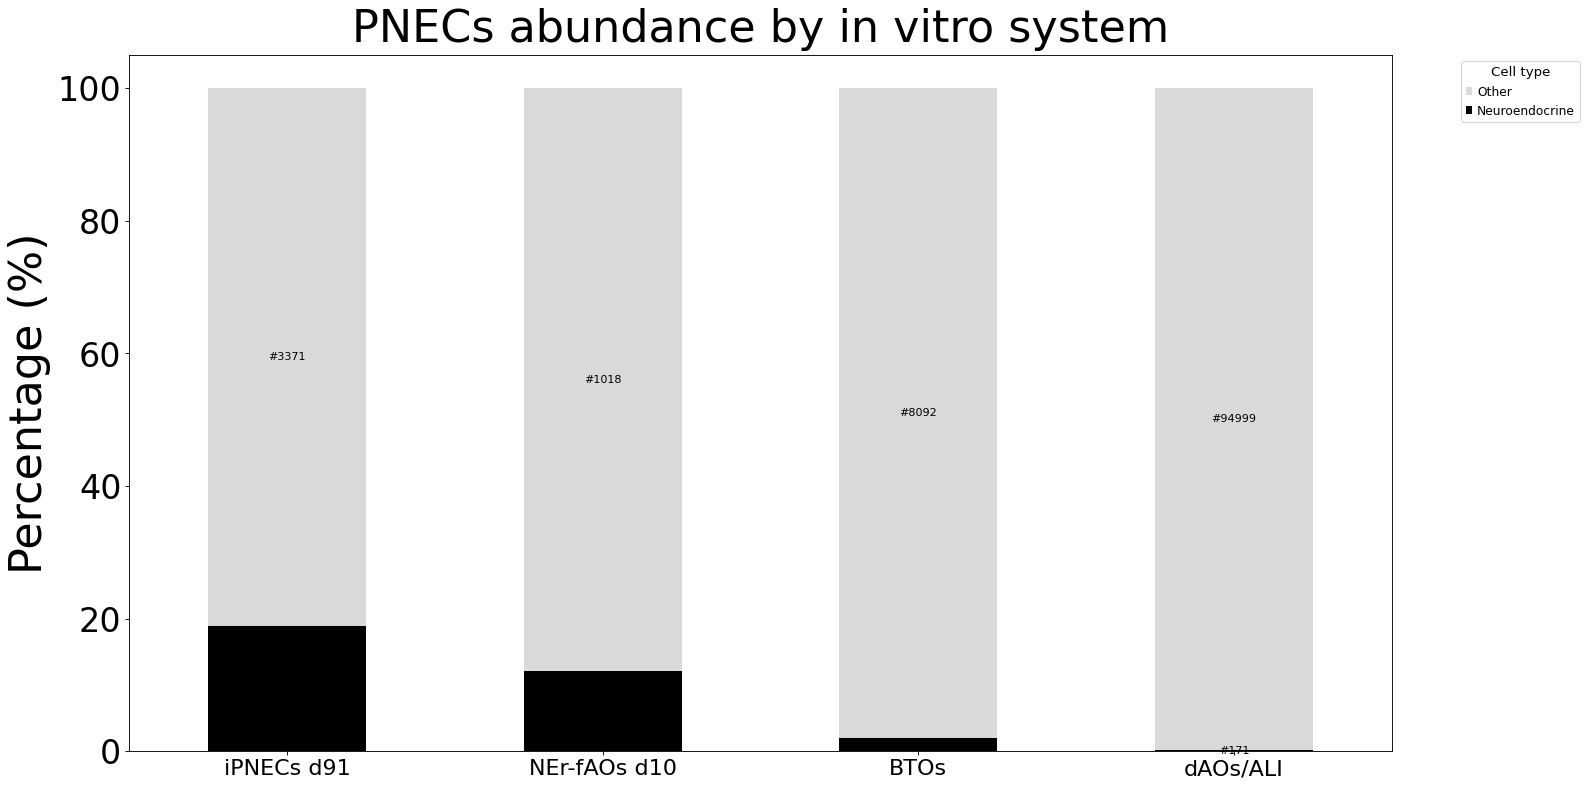

In [29]:
import matplotlib.pyplot as plt
import os

# Calculate counts for each media outside the loop
counts = df.groupby('System')['Neuroendocrine'].value_counts()

# Group by and calculate the percentage of each category
grouped_df = df.groupby('System')['Neuroendocrine'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('System')
order = ['iPNECs d91','NEr-fAOs d10','BTOs','dAOs/ALI']
grouped_df = grouped_df.loc[order]

# Reorder the 'Neuroendocrine' categories
grouped_df = grouped_df[['Neuroendocrine','Other']]  # This assumes these are the two categories

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(20,10))

# Plot the bar chart
grouped_df.plot(kind='bar', stacked=True, alpha=1, color=['black','#d9d9d9'], ax=ax)

# Annotate the bars with the counts
i = 0
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    media = order[i % len(order)]
    i += 1
    counts = df.groupby('System')['Neuroendocrine'].value_counts()
    total_counts = counts.loc[media].sum()
    count = round(height / 100 * total_counts)
    if count == 0:
        continue
    ax.annotate(f'#{count}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10)
    

# Customize the plot
plt.title('PNECs abundance by in vitro system',size=40, pad=12)
plt.xlabel('', size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=40, labelpad=6)
plt.yticks(rotation=0, size=30)
plt.xticks(rotation=0, size=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join(figfolder, 'StackedPlot_Neuroendocrine_systems_numbered'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


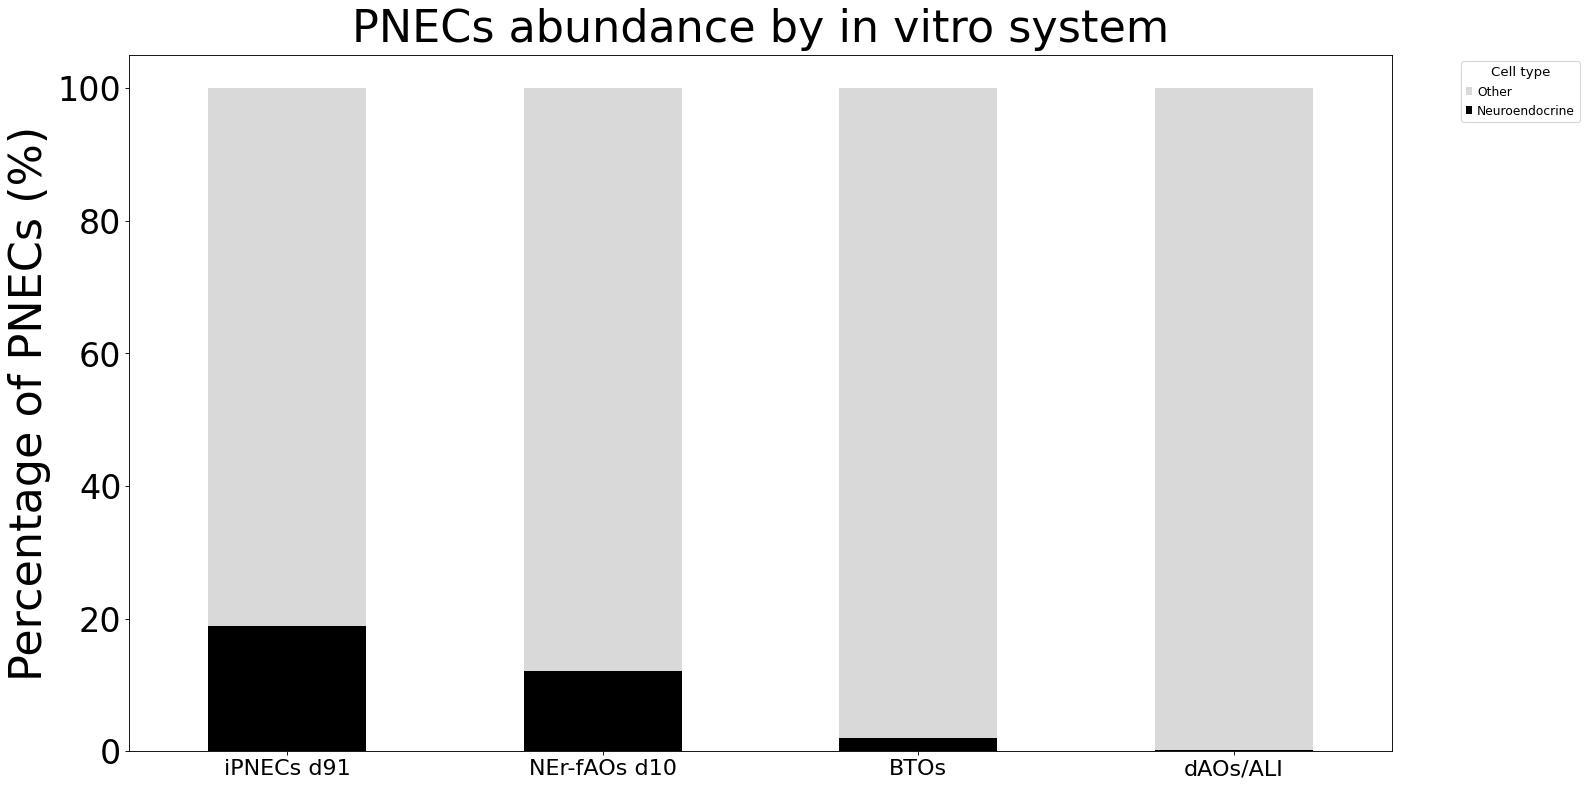

In [30]:
import matplotlib.pyplot as plt
import os

# Calculate counts for each media outside the loop
counts = df.groupby('System')['Neuroendocrine'].value_counts()

# Group by and calculate the percentage of each category
grouped_df = df.groupby('System')['Neuroendocrine'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('System')
order = ['iPNECs d91','NEr-fAOs d10','BTOs','dAOs/ALI']
grouped_df = grouped_df.loc[order]

# Reorder the 'Neuroendocrine' categories
grouped_df = grouped_df[['Neuroendocrine','Other']]  # This assumes these are the two categories

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(20,10))

# Plot the bar chart
grouped_df.plot(kind='bar', stacked=True, alpha=1, color=['black','#d9d9d9'], ax=ax)
    

# Customize the plot
plt.title('PNECs abundance by in vitro system',size=40, pad=12)
plt.xlabel('', size=18, labelpad=6)
plt.ylabel('Percentage of PNECs (%)', size=40, labelpad=6)
plt.yticks(rotation=0, size=30)
plt.xticks(rotation=0, size=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join(figfolder, 'StackedPlot_Neuroendocrine_systems'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


# PREPROCESSING: Merge Neuroendocrine

In [31]:
adata = sc.read_h5ad('./data/Merged_Neuroendocrine.h5ad')
adata

AnnData object with n_obs × n_vars = 2838 × 56999
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [32]:
categories = pd.unique(adata.obs['Technique'])
# Printing the categories
for category in categories:
    print(category)

10x
SORT-seq


In [33]:
categories = pd.unique(adata.obs['Tissue'])
# Printing the categories
for category in categories:
    print(category)

iPNECs
BTOs
dAOs/ALI
NEr-fAOs
Fetal
Adult


In [34]:
categories = pd.unique(adata.obs['Sample ID'])
# Printing the categories
for category in categories:
    print(category)

iPSdiff_1
iPSdiff_2
Conchola2023CellTagging
Chromium018
Chromium019
Chromium046
Chromium047
Chromium038
Chromium118
s066
s062
s063
s090
s004
s007
f103dairway
f103ddistal
f125dairway
f132ddistal
f125ddistal
f59dairway
f59ddistal
f80dairway
f80ddistal
f103dtrach
f145dtrach
D353_BIOP_INT2
D353_BIOP_PRO1
D367_BIOP_PRO1
D367_BIOP_INT1
D339_BIOP_INT1
D354_BIOP_INT2
D372_BIOP_INT2
D372_BIOP_PRO1
D344_BIOP_INT1
D326_BIOP_PRO1
D326_BIOP_INT1
GSM3489191
GSM3489195
GSM3489197
T101
T120
T121
T126
T153
T154
T164
T165
T166
T167
T84
T85
T89
T90
HD67
syn21041850_P1_2
syn21041850_P3_3
syn21041850_P3_2
syn21041850_P3_6
AEL4146-1
AEL4146-2
AFAE328-2
AFAE328-1
AFEW459-1
AFEW459-2
AFGF420-1
AFGF420-2
AGAH121-2
AGJN070-1
AHJP457-1
AICU191-1
222C
098C-a
098C-b
133C-a
253C
388C


In [35]:
categories = pd.unique(adata.obs['Reference'])
# Printing the categories
for category in categories:
    print(category)

Hor et al., (2020)
Conchola et al., (2023) - BTOs
Lee et al., (2023)
Candeli et al., (2025)
Conchola et al., (2023) - Fetal
Deprez et al., (2020)
Reyfman et al., (2019)
Goldfarbmuren et al., (2020)
Habermann et al., (2019)
Travaglini et al., (2020)
Guo et al., (2023)
Adams et al., (2020)


In [36]:
print(adata.var_names.duplicated().any())

False


In [37]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=17590.0, mean=0.14969097846888033


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.14969097846888033


Raw matrix (raw.X): min=0.0, max=17590.0, mean=0.14969097846888033
Scaled layer not found in adata.layers.


In [38]:
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [39]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [40]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [41]:
adata.var['rp'] = adata.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)

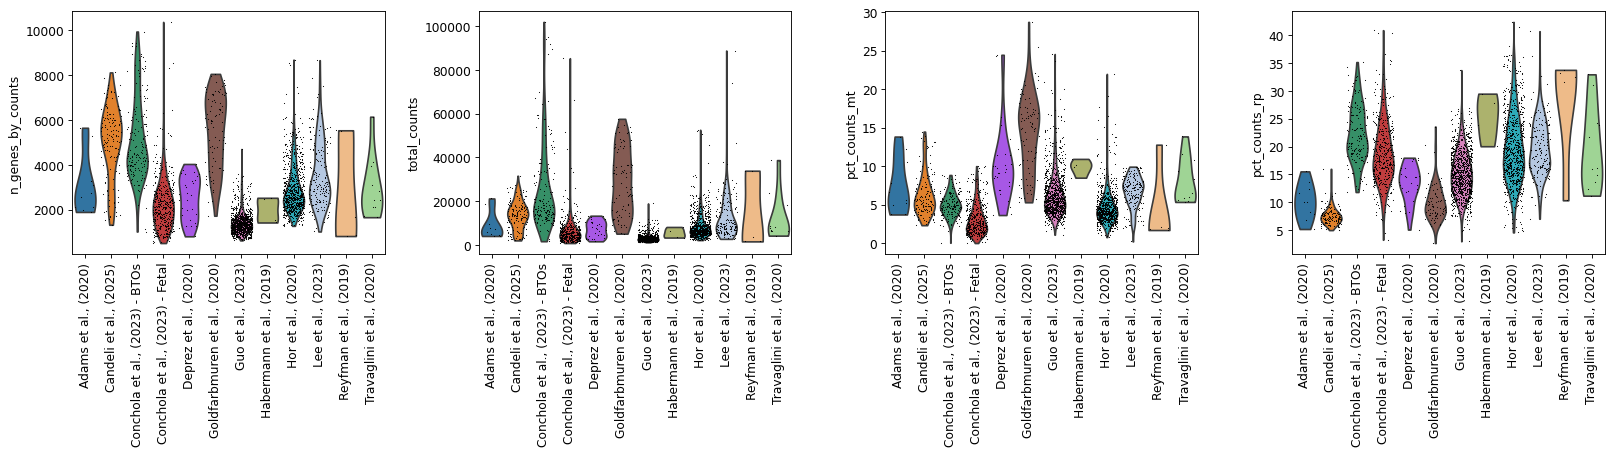

In [42]:
sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rp'],jitter=0.4, groupby = 'Reference', rotation= 90)

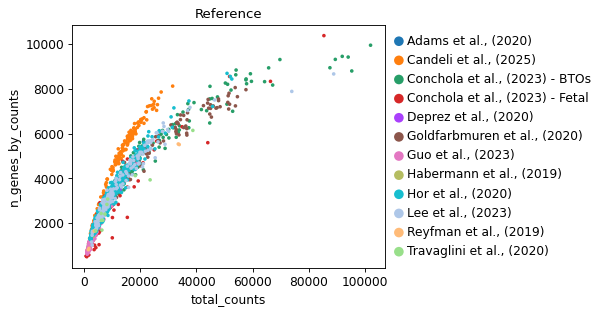

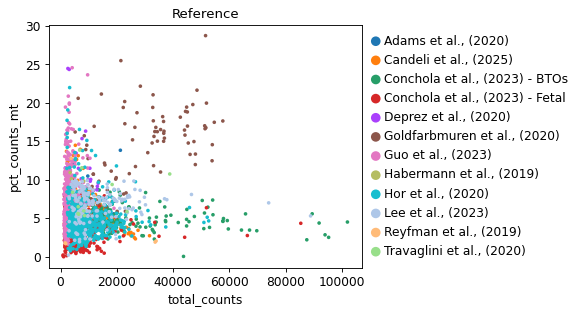

In [43]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color='Reference')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',color='Reference')

## Normalization & Highly Variable Genes

In [44]:
# Save counts layer
adata.layers["counts"] = adata.X.copy()

# Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata)

adata.raw = adata.copy()
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [45]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=0.0, max=8.921710102379791, mean=0.11487480372695755


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.33038913503957706


Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.11487480372695755
Scaled layer not found in adata.layers.


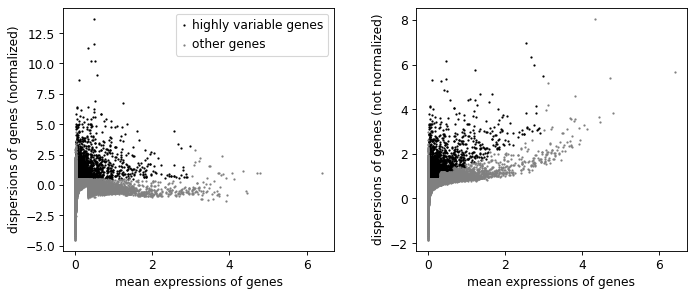

In [46]:
# highly-variable genes are selected
sc.pp.highly_variable_genes(adata, layer=None, n_top_genes=None, min_disp=0.5, min_mean=0.0125,
                                max_mean=3, span=0.3, n_bins=20, flavor='seurat', 
                                subset=False, inplace=True,batch_key=None, check_values=True)
sc.pl.highly_variable_genes(adata)

## Regress out (mostly) unwanted sources of variation.

In [47]:
# Parsing of Cell Cycle genes file
cell_cycle_genes = [x.strip() for x in open ('./data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [48]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


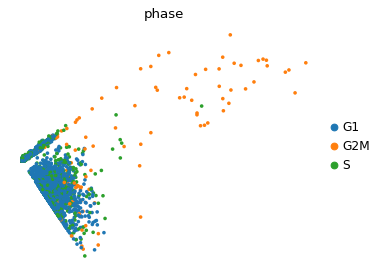

In [49]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')

... storing 'phase' as categorical


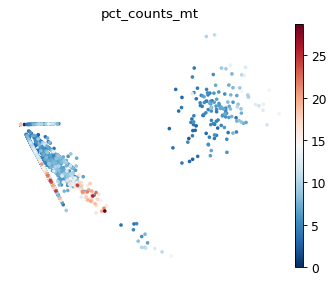

In [50]:
# We will plot the PCA of the 'pct_counts_mt' source of variation

adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')

... storing 'phase' as categorical


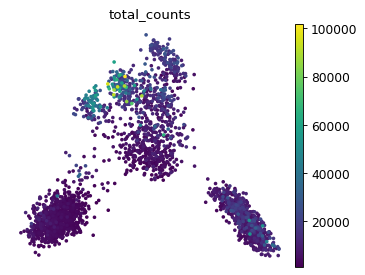

In [51]:
# We will plot the PCA of the total counts' source of variation
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [52]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt",'S_score','G2M_score'])

... storing 'phase' as categorical


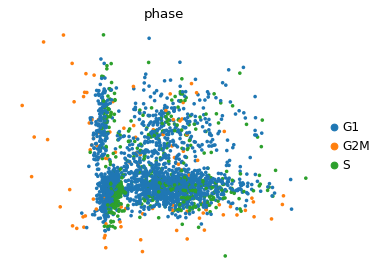

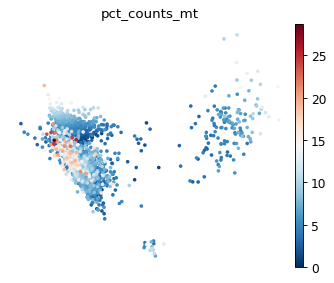

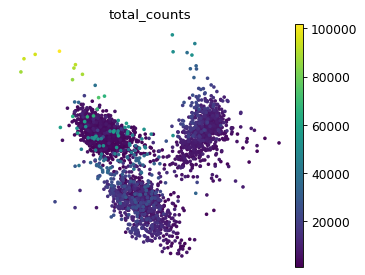

In [53]:
# Plot PCA again after regression
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

## Scaling of the data

In [54]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=-6.235107326478655, max=8.199231881195244, mean=9.144117855883753e-16


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.33038913503957706


Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.11487480372695755
Scaled layer not found in adata.layers.


In [55]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X.copy()
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [56]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=-6.235107326478655, max=8.199231881195244, mean=9.144117855883753e-16


Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.33038913503957706


Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.11487480372695755
Scaled layer matrix (layers['scaled']): min=-11.434715632360767, max=52.91631607896743, mean=-4.879744705446661e-17


## Compute PCA

In [57]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

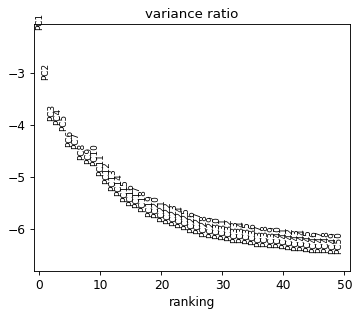

In [58]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

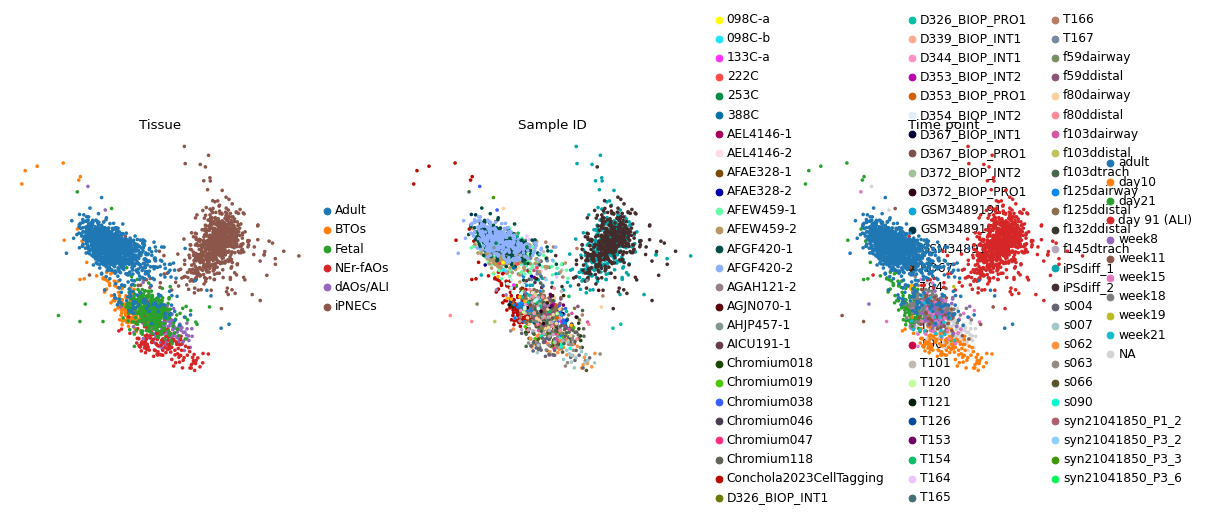

In [59]:
sc.pl.pca_scatter(adata,color=['Tissue', 'Sample ID', 'Time point'])

In [60]:
adata.write_h5ad('./data/Merged_Neuroendocrine_processed.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## Export Merged_Neuroendocrine_processed Data (for MrVI)

In [61]:
#adata=sc.read_h5ad('./data/Merged_Neuroendocrine_processed.h5ad')
columns_to_keep = ['Sample ID', 'Technique', 'Tissue']
columns_to_remove = [column for column in adata.obs.columns if column not in columns_to_keep]
adata.obs = adata.obs.drop(columns=columns_to_remove)
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Tissue', 'Technique'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'log1p', 'hvg', 'pca', 'Tissue_colors', 'Sample ID_colors', 'Time point_colors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced', 'scaled'

In [62]:
import scipy.sparse as sp
from scipy.io import mmwrite
import io

mmwrite('./data/Merged_Neuroendocrine_matrix.mtx', adata.layers['counts'])

In [63]:
# Write gene names to tsv
with open ('./data/Merged_Neuroendocrine_var_genes.tsv','w') as f:
    for item in adata.var_names:
        f.write(item + '\n')

In [64]:
# Write cell names to tsv
with open ('./data/Merged_Neuroendocrine_obs_cells.tsv','w') as f:
    for item in adata.obs_names:
        f.write(item + '\n')

In [65]:
# Write metadata to csv
df = pd.DataFrame(adata.obs)
df.to_csv('./data/Merged_Neuroendocrine_metadata.csv', index=False)
df

,Sample ID,Tissue,Technique
AAACGGGCATGGTAGG-1,iPSdiff_1,iPNECs,10x
AAACGGGGTATAAACG-1,iPSdiff_1,iPNECs,10x
AAACGGGTCGGAAATA-1,iPSdiff_1,iPNECs,10x
AAATGCCTCCACTCCA-1,iPSdiff_1,iPNECs,10x
AACCATGGTACCGTAT-1,iPSdiff_1,iPNECs,10x
...,...,...,...
133C-a_AAATGCCGTTAAGGGC,133C-a,Adult,10x
253C_CCCAATCAGGCGCTCT,253C,Adult,10x
253C_CCTCTGACATGGTCAT,253C,Adult,10x
253C_GGCCGATCAGGGTATG,253C,Adult,10x
